In [1]:
import pickle
from fastai.vision.all import *

# Data preparation

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [3]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [4]:
# (path/'train'/'3').ls()
(path / "valid").ls()

(#2) [Path('valid/3'),Path('valid/7')]

list of paths to all images of 3 and 7

In [5]:
threes_path = (path / "train/3").ls().sorted()
sevens_path = (path / "train/7").ls().sorted()
len(threes_path), len(sevens_path)

(6131, 6265)

function to invert image (black handwriting on white)

In [6]:
def invert_image(img):
    # Convert PIL image to tensor, invert colors (255 - pixel_value), and return tensor
    return 255 - tensor(img)

tensors of all images of 3 and 7

In [7]:
# Create tensors for both normal and inverted images
three_tensors = []
seven_tensors = []

# Process threes
for img_path in threes_path:
    img = Image.open(img_path)
    # Add normal image tensor
    three_tensors.append(tensor(img))
    # Add inverted image tensor
    three_tensors.append(invert_image(img))

# Process sevens
for img_path in sevens_path:
    img = Image.open(img_path)
    # Add normal image tensor
    seven_tensors.append(tensor(img))
    # Add inverted image tensor
    seven_tensors.append(invert_image(img))

print("Number of tensors (including inverted):", len(three_tensors), len(seven_tensors))

Number of tensors (including inverted): 12262 12530


`show_image()` is a function of fastai, that takes a tensor and returns an image 

<Axes: >

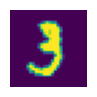

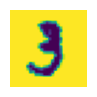

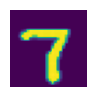

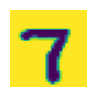

In [8]:
show_image(three_tensors[0])
show_image(three_tensors[1])
show_image(seven_tensors[0])
show_image(seven_tensors[1])

stacked tensor of tensors of images. So a 3D tensor. A list of matrices.

In [9]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255
# stacked_threes[1], stacked_sevens[1]

Creating input data for training set by changing 3D to 2D tensor, a list of vectors. Also concatenating 3 and 7 tensors.

In [10]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

creating labels for training set, by labelling a 3 as 1 or True, and 7 as 0 or False.

In [11]:
train_y = tensor([1] * len(three_tensors) + [0] * len(seven_tensors)).unsqueeze(1)

Creating a `Dataset` object

In [12]:
dset = list(zip(train_x, train_y))

In [13]:
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Now, we also create a validation dataset

In [14]:
valid_3_list = []
valid_7_list = []

path_3 = (path)
for img_path in (path / "valid/3").ls().sorted():
    image = Image.open(img_path)
    valid_3_list.append(tensor(image))
    valid_3_list.append(invert_image(image))
 
for img_path in (path / "valid/7").ls().sorted():
    image = Image.open(img_path)
    valid_7_list.append(tensor(image))
    valid_7_list.append(invert_image(image))

print(f"length of validation datasets: {len(valid_3_list)=}; {len(valid_7_list)=}")

length of validation datasets: len(valid_3_list)=2020; len(valid_7_list)=2056


In [15]:
# valid_3_tens = torch.stack(
#     [tensor(Image.open(o)) for o in (path / "valid/3").ls().sorted()]
# )
# valid_3_tens = valid_3_tens.float() / 255
# valid_7_tens = torch.stack(
#     [tensor(Image.open(o)) for o in (path / "valid/7").ls().sorted()]
# )
# valid_7_tens = valid_7_tens.float() / 255

In [16]:
valid_3_tens = torch.stack(valid_3_list).float() / 255
valid_7_tens = torch.stack(valid_7_list).float() / 255

(torch.Size([28, 28]), <Axes: >, <Axes: >)

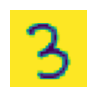

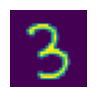

In [17]:
valid_3_tens[0].shape, show_image(valid_3_tens[1]), show_image(valid_3_tens[0])

successful!

In [18]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [19]:
type(valid_dset[0][0]), len(valid_dset)

(torch.Tensor, 4076)

# Model Creation

function to initialize random `weights` or `parameters`

In [20]:
torch.manual_seed(0)


def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

In [21]:
weights = init_params((28 * 28, 1))  # image size is 28*28

since the equation is (check notes on why this is the equation) y = w*x + b, we also initialize a random bias

In [22]:
bias = init_params(1)

In [23]:
type(train_x), train_x.shape

(torch.Tensor, torch.Size([24792, 784]))

Create the model

In [24]:
def linear1(xb):
    return xb @ weights + bias


preds = linear1(train_x)
preds

tensor([[ 5.8740],
        [44.5086],
        [-2.5629],
        ...,
        [39.6594],
        [ 9.5250],
        [40.8575]], grad_fn=<AddBackward0>)

for calculating accuracy we create `corrects` tensor

In [25]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [26]:
corrects.float().mean().item()

0.4847128093242645

for loss function, basic idea is,

In [27]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

Not going to use the above function, since pytorch already provides an in-built sigmoid function

In [28]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

creating a dataloader for batching of test dataset

In [29]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

same for validation set

In [30]:
valid_dl = DataLoader(valid_dset, batch_size=256)

**putting everything together**
the process will be something like this

```for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad*lr
```

In [31]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

one epoch will be,

In [32]:
def train_epoch(model, lr, params):
    for xb, yb in dl:  # for each batch in dataloader
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

for calculating accuracy of a batch

In [33]:
def batch_accuracy(xb, yb):  # here xb and yb denote a single batch of dataset
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb  # correct is a boolean array
    return (
        correct.float().mean()
    )  # converting correct boolean to float and calculating mean

putting batches together

In [34]:
def validate_epoch(model):
    accs = [
        batch_accuracy(model(xb), yb) for xb, yb in valid_dl
    ]  # for each batch in dataloader
    return round(torch.stack(accs).mean().item(), 4)

first train for one epoch

In [35]:
lr = 1.0
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5632

then setup a loop

In [36]:
for i in range(40):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=" ")

0.5351 0.591 0.6977 0.7079 0.6977 0.7079 0.714 0.7177 0.714 0.7177 0.7192 0.7209 0.7192 0.7209 0.7226 0.7228 0.7226 0.7228 0.7233 0.7245 0.7233 0.7245 0.7248 0.7253 0.7248 0.7253 0.7258 0.7268 0.7258 0.7268 0.728 0.7285 0.728 0.7285 0.7287 0.729 0.7287 0.729 0.729 0.7297 0.729 0.7297 0.73 0.73 0.73 0.73 0.73 0.73 0.73 0.73 0.7304 0.7307 0.7304 0.7307 0.7309 0.7309 0.7309 0.7309 0.7309 0.7317 0.7309 0.7317 0.7317 0.7319 0.7317 0.7319 0.7322 0.7322 0.7322 0.7322 0.7322 0.7324 0.7322 0.7324 0.7324 0.7326 0.7324 0.7326 

we can see that the accuracy is certainly getting better

create a function to predict output for an image

In [37]:
def final_predict(image_tensor):
    out = linear1(image_tensor)
    if out > 0.5:
        return 3
    return 7

In [38]:
def accuracy(dl):
    # for xb,yb in dl:
    #     corrects = (linear1(xb).sigmoid()>0.5).float()

    corrects = [(linear1(xb).sigmoid() > 0.5).float() for xb, yb in dl]
    return torch.stack(corrects).float().mean()

In [39]:
def save_model(weights, bias, filename="mnist_model.pkl"):
    model_params = {"weights": weights.detach().numpy(), "bias": bias.detach().numpy()}
    with open(filename, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Model saved to {filename}")

In [40]:
def load_model(filename="mnist_model.pkl"):
    with open(filename, "rb") as f:
        model_params = pickle.load(f)

    # Convert numpy arrays back to tensors and set requires_grad
    loaded_weights = torch.tensor(model_params["weights"], requires_grad=True)
    loaded_bias = torch.tensor(model_params["bias"], requires_grad=True)

    return loaded_weights, loaded_bias

In [41]:
# Save the trained model
save_model(weights, bias, "../models/mnist_model.pkl")

Model saved to ../models/mnist_model.pkl


In [42]:
def predict_from_file(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        img = img.resize((28, 28))  # Resize to match MNIST format

        # Convert to tensor and normalize
        img_tensor = tensor(np.array(img)).float() / 255
        img_tensor = img_tensor.view(-1, 28 * 28)  # Reshape to match model input

        # Get prediction
        out = linear1(img_tensor)
        prediction = 3 if out.item() > 0.5 else 7
        confidence = torch.sigmoid(out).item()
        confidence = confidence if prediction == 3 else 1 - confidence

        print(f"Predicted digit: {prediction}")
        print(f"Confidence: {confidence:.2%}")
        return prediction, confidence

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None

Predicted digit: 7
Confidence: 100.00%


<Axes: >

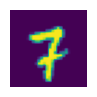

In [43]:
# Example usage:
test_image_path = str(
    path / "valid/7/328.png"
)  # Using a test image from the validation set
prediction, confidence = predict_from_file(test_image_path)

# Display the image
img = Image.open(test_image_path)
show_image(tensor(img))